In [1]:
!python --version
!pip install tensorflow==2.11.0
!pip install git+https://github.com/VenkateshwaranB/stellargraph.git

Python 3.10.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 24.6 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: keras
    Found existing ins

  Cloning https://github.com/VenkateshwaranB/stellargraph.git to /tmp/pip-req-build-fi_9cere
  Running command git clone --filter=blob:none --quiet https://github.com/VenkateshwaranB/stellargraph.git /tmp/pip-req-build-fi_9cere
  Resolved https://github.com/VenkateshwaranB/stellargraph.git to commit efa1f847109a4ba490e7a5105646a20ee09a3243
  Preparing metadata (setup.py) ... done
  Created wheel for stellargraph: filename=stellargraph-1.3.0b0-py3-none-any.whl size=431845 sha256=9f4ba21caab30551a501e73e99ec4724177779f564db3680e34462c9f85311b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-iv32lfqr/wheels/f3/06/0f/089f69af27d308a1830638f855b6c5755311d8ffc451de9980
Successfully built stellargraph


In [3]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML

# Load the dataset and display information
dataset_info = datasets.Cora()
display(HTML(dataset_info.description))
graph_data, _ = dataset_info.load(subject_as_feature=True)

print(graph_data.info())


StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


** Sampled 542 positive and 542 negative edges. **
** Sampled 488 positive and 488 negative edges. **
Using GCN (local pooling) filters...
Using GCN (local pooling) filters...


1/1 [==============================] - 0s 338ms/step - loss: 1.8846 - acc: 0.0000e+00

Train Set Metrics of the initial (untrained) model:
	loss: 1.8762
	acc: 0.0000

Test Set Metrics of the initial (untrained) model:
	loss: 1.8846
	acc: 0.0000
Epoch 1/55
1/1 - 5s - loss: 1.7519 - acc: 0.0000e+00 - val_loss: 1.6041 - val_acc: 0.0000e+00 - 5s/epoch - 5s/step
Epoch 2/55
1/1 - 0s - loss: 1.5772 - acc: 0.0000e+00 - val_loss: 1.3666 - val_acc: 0.0000e+00 - 356ms/epoch - 356ms/step
Epoch 3/55
1/1 - 0s - loss: 1.3138 - acc: 0.0000e+00 - val_loss: 1.1648 - val_acc: 0.0000e+00 - 210ms/epoch - 210ms/step
Epoch 4/55
1/1 - 0s - loss: 1.1360 - acc: 0.0000e+00 - val_loss: 0.9954 - val_acc: 0.0000e+00 - 159ms/epoch - 159ms/step
Epoch 5/55
1/1 - 0s - loss: 0.9825 - acc: 0.0000e+00 - val_loss: 0.8583 - val_acc: 0.0000e+00 - 157ms/epoch - 157ms/step
Epoch 6/55
1/1 - 0s - loss: 0.8563 - acc: 0.0000e+00 - val_loss: 0.7771 - val_acc: 0.0000e+00 - 137ms/epoch - 137ms/step
Epoch 7/55
1/1 - 0s - loss: 0.7637 

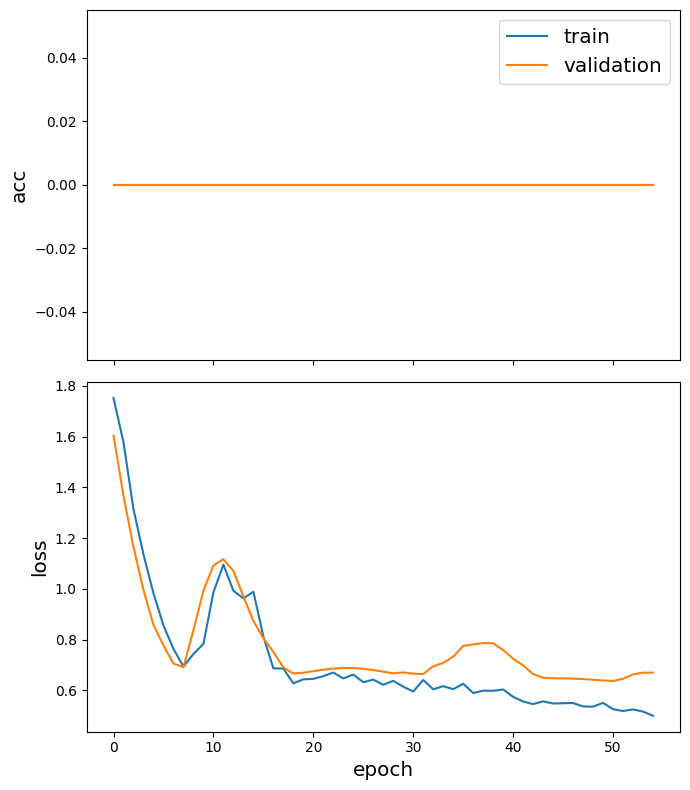

In [4]:
# Define edge splitters for train and test datasets
test_edge_splitter = EdgeSplitter(graph_data)

# Sample positive and negative links, then create reduced graph for testing
test_graph, test_edge_ids, test_edge_labels = test_edge_splitter.train_test_split(
    p=0.1, method="global", keep_connected=True
)

# Define another edge splitter for training
train_edge_splitter = EdgeSplitter(test_graph)

# Sample positive and negative links, then create reduced graph for training
train_graph, train_edge_ids, train_edge_labels = train_edge_splitter.train_test_split(
    p=0.1, method="global", keep_connected=True
)

# Define training and testing configurations
training_epochs = 55
train_generator = FullBatchLinkGenerator(train_graph, method="gcn")
train_flow_data = train_generator.flow(train_edge_ids, train_edge_labels)
test_generator = FullBatchLinkGenerator(test_graph, method="gcn")
test_flow_data = test_generator.flow(test_edge_ids, test_edge_labels)

# Create GCN model
gcn_model = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_generator, dropout=0.3
)
input_tensors, output_tensors = gcn_model.in_out_tensors()
link_prediction = LinkEmbedding(activation="relu", method="ip")(output_tensors)
link_prediction = keras.layers.Reshape((-1,))(link_prediction)

model = keras.Model(inputs=input_tensors, outputs=link_prediction)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

# Evaluate initial model performance
initial_train_metrics = model.evaluate(train_flow_data)
initial_test_metrics = model.evaluate(test_flow_data)

print("\nTrain Set Metrics of the initial (untrained) model:")
for metric_name, metric_value in zip(model.metrics_names, initial_train_metrics):
    print(f"\t{metric_name}: {metric_value:.4f}")

print("\nTest Set Metrics of the initial (untrained) model:")
for metric_name, metric_value in zip(model.metrics_names, initial_test_metrics):
    print(f"\t{metric_name}: {metric_value:.4f}")

# Train the model
training_history = model.fit(
    train_flow_data, epochs=training_epochs, validation_data=test_flow_data, verbose=2, shuffle=False
)

# Plot training history
sg.utils.plot_history(training_history)

# Evaluate trained model performance
final_train_metrics = model.evaluate(train_flow_data)
final_test_metrics = model.evaluate(test_flow_data)

print("\nTrain Set Metrics of the trained model:")
for metric_name, metric_value in zip(model.metrics_names, final_train_metrics):
    print(f"\t{metric_name}: {metric_value:.4f}")

print("\nTest Set Metrics of the trained model:")
for metric_name, metric_value in zip(model.metrics_names, final_test_metrics):
    print(f"\t{metric_name}: {metric_value:.4f}")
